In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sea
from scipy import stats
import matplotlib.pyplot as plt
from housing_elements import utils, los_altos_permits, san_francisco_permits, san_jose_permits, map_utils
from pathlib import Path

In [2]:
from importlib import reload
reload(los_altos_permits)
reload(san_francisco_permits)
reload(utils)

<module 'housing_elements.utils' from '/Users/Salim/Desktop/housing-elements/housing_elements/utils.py'>

In [3]:
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [4]:
# Silence an annoying warning that I get when running pd.read_excel
import warnings
warnings.filterwarnings("ignore", message="Data Validation extension is not supported and will be removed")

# Load sites and permits DataFrames for each city

In [5]:
sites_df = utils.load_all_sites()

In [6]:
all_cities = sites_df.jurisdict.unique()

In [7]:
len(all_cities)

108

In [8]:
%%time
cities_with_sites = {}

for city in all_cities:
    with HiddenPrints():
        try:
            sites = utils.load_site_inventory(city)
            assert sites.shape[0]
            cities_with_sites[city] = sites
        except Exception:
            print(city, file=sys.stderr)

Orinda
Foster City


CPU times: user 11 s, sys: 131 ms, total: 11.2 s
Wall time: 11.2 s


In [9]:
len(cities_with_sites)

106

In [10]:
%%time
cities_with_permits = {}

for city in all_cities:
    with HiddenPrints():
        try:
            cities_with_permits[city] = utils.load_all_new_building_permits(city)
        except Exception:
            print(city, file=sys.stderr)

/Users/Salim/Library/Caches/pypoetry/virtualenvs/housing-elements-_yehc9l1-py3.8/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
Contra Costa County
Alameda County
Marin County
Saint Helena
Napa County
/Users/Salim/Library/Caches/pypoetry/virtualenvs/housing-elements-_yehc9l1-py3.8/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
Hillsborough
San Mateo County
Sonoma County


CPU times: user 2min 19s, sys: 1.44 s, total: 2min 20s
Wall time: 2min 21s


Solano County


In [11]:
len(cities_with_permits)

99

In [12]:
len(set(cities_with_permits).intersection(set(cities_with_sites)))

97

## Dump match results to JSON, for use in website

In [13]:
reload(utils)
reload(map_utils)
map_utils.write_matches_to_files(
    cities_with_sites,
    cities_with_permits,
    Path('./map_results')
)

100%|██████████| 106/106 [01:39<00:00,  1.06it/s]


## Data Cleaning Factoids

### Realistic Capacity

#### Pre-Existing Nulls

Two ways to calculate NA realistic capacities come to the same conclusion

In [14]:
rhna5 = sites_df[sites_df.rhnacyc == 'RHNA5']

In [15]:
rhna5.relcapcty[rhna5.relcapcty.isna()].shape

(2910,)

In [16]:
rhna5[(rhna5.relcapcty.str.contains("/^([^0-9]*)$/") != False)].shape

/Users/Salim/Library/Caches/pypoetry/virtualenvs/housing-elements-_yehc9l1-py3.8/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


(2910, 35)

In [17]:
rhna5.shape

(20849, 35)

In [18]:
2910 / rhna5.shape[0]

0.13957503957024317

### Proportion of nulls that are our fault versus theirs

In [19]:
for city, site in cities_with_sites.items():
    num_fail_parse_realcap = site.realcap_parse_fail.sum()
    if num_fail_parse_realcap:
        print(city, end='\t')
        print('Realcap', num_fail_parse_realcap)

In [20]:
sum([site.realcap_parse_fail.sum() for city, site in cities_with_sites.items()])

0

None of the realistic capacity nulls are our fault.

#### Degenerate Rows

In [21]:
no_realcap = pd.to_numeric(rhna5.relcapcty, errors='coerce') == 0
no_locacreage = pd.to_numeric(rhna5.locacres, errors='coerce') == 0
no_gacreage = pd.to_numeric(rhna5.gacres, errors='coerce') == 0

In [22]:
rhna5[no_realcap & no_locacreage].shape

(14, 35)

In [23]:
rhna5[no_gacreage & no_locacreage].shape

(0, 35)

In [24]:
rhna5[no_gacreage].shape

(0, 35)

I wouldn't say there are any degenerate rows. Even when locacreage is zero, we can rely on gacreage instead. 

There are, however, 901 sites with no realistic capacity and no allowable density. What kind of sites are these?

They're mostly in San Francisco and have a zoning type of PDR. According to SF's website, "In order to protect PDR, residential development would be prohibited, while office, retail, and institutional uses (schools, hospitals, etc.) would be limited. HOWEVER, residences, offices and retail which currently exist legally in these areas may stay indefinitely."


In [25]:
sf_sites = cities_with_sites['San Francisco']
sf_sites_fixed = sf_sites[
    sf_sites['relcapcty'] != 0
]
cities_with_sites['San Francisco'] = sf_sites_fixed

In [26]:
sf_sites.shape

(5254, 31)

## Results

In [27]:
def get_results_for_city(city: str, match_by: str) -> pd.DataFrame:
    permits = cities_with_permits[city]
    sites = cities_with_sites[city]
    
    nonvacant_matches, nonvacant_sites, nonvacant_ratio = utils.calculate_pdev_for_nonvacant_sites(sites, permits, match_by)
    vacant_matches, vacant_sites, vacant_ratio = utils.calculate_pdev_for_vacant_sites(sites, permits, match_by)
    all_matches, all_sites, all_ratio = utils.calculate_pdev_for_inventory(sites, permits, match_by)
    
    return {
        'City': city,
        'Mean underproduction': utils.calculate_underproduction_on_sites(sites, permits),
        'RHNA Success': utils.calculate_rhna_success(city, permits),
        'P(inventory) for homes built': utils.calculate_pinventory_for_dev(sites, permits),
        'P(dev) for nonvacant sites': nonvacant_ratio,
        'P(dev) for vacant sites': vacant_ratio,
        'P(dev) for inventory': all_ratio,
        '# nonvacant matches': f'{nonvacant_matches} / {nonvacant_sites}',
        '# vacant matches': f'{vacant_matches} / {vacant_sites}',
        '# matches': f'{all_matches} / {all_sites}',
    }

In [28]:
cities = [city for city in all_cities if city in cities_with_permits and city in cities_with_sites]

In [29]:
len(cities)

97

In [30]:
%%time
reload(utils)
with HiddenPrints():
    results_df = pd.DataFrame([get_results_for_city(city, match_by='apn') for city in cities])

CPU times: user 32.5 s, sys: 266 ms, total: 32.7 s
Wall time: 32.7 s


In [31]:
results_df

,City,Mean underproduction,RHNA Success,P(inventory) for homes built,P(dev) for nonvacant sites,P(dev) for vacant sites,P(dev) for inventory,# nonvacant matches,# vacant matches,# matches
0,Berkeley,1.255423,0.632308,0.040620,0.011976,0.025316,0.019802,2 / 167,6 / 237,8 / 404
1,Albany,NaN,0.770149,0.000000,0.000000,0.000000,0.000000,0 / 17,0 / 8,0 / 41
2,Alameda,NaN,0.697040,0.000000,0.000000,0.000000,0.000000,0 / 7,0 / 11,0 / 18
3,Livermore,1.238385,0.729938,0.244980,0.074468,0.165049,0.118812,7 / 94,17 / 103,24 / 202
4,Fremont,0.437540,1.103575,0.112126,0.028369,0.047619,0.030864,4 / 141,1 / 21,5 / 162
...,...,...,...,...,...,...,...,...,...,...
92,Monte Sereno,NaN,0.770492,0.000000,0.000000,NaN,0.000000,0 / 5,0 / 0,0 / 6
93,Healdsburg,0.278571,1.592357,0.028000,0.095238,0.083333,0.083333,2 / 21,3 / 36,5 / 60
94,Fairfield,0.300000,0.662581,0.001461,0.000000,0.025974,0.023256,0 / 2,2 / 77,2 / 86
95,Sonoma,0.102564,1.021898,0.028571,0.000000,0.200000,0.043478,0 / 13,1 / 5,1 / 23


In [32]:
for city, permits in cities_with_permits.items():
    print(city, '\t', round(utils.fraction_apns_nan(permits), 2))

Berkeley 	 0.01
Albany 	 0.01
Alameda 	 0.43
Livermore 	 0.01
Fremont 	 0.4
San Ramon 	 0.01
Newark 	 0.34
Brentwood 	 0.27
Hayward 	 0.29
Emeryville 	 0.14
Pleasanton 	 0.15
San Leandro 	 0.04
Concord 	 0.39
Richmond 	 0.02
Martinez 	 0.52
Clayton 	 0.75
Pinole 	 0.33
Oakland 	 0.33
San Francisco 	 0.19
Dublin 	 0.77
Antioch 	 0.25
Lafayette 	 0.03
Danville 	 0.32
San Pablo 	 0.19
Napa 	 0.21
El Cerrito 	 0.16
Union City 	 0.12
Walnut Creek 	 0.38
Corte Madera 	 0.05
Moraga 	 0.06
Hercules 	 0.23
Oakley 	 0.25
Orinda 	 0.18
Pittsburg 	 0.53
Pleasant Hill 	 0.38
American Canyon 	 0.56
Larkspur 	 0.51
Piedmont 	 0.0
San Rafael 	 0.02
Calistoga 	 0.12
Tiburon 	 0.0
Sausalito 	 0.36
Yountville 	 0.27
San Anselmo 	 0.29
Belvedere 	 0.43
Fairfax 	 0.06
Ross 	 0.17
Novato 	 0.2
Half Moon Bay 	 0.25
Millbrae 	 0.22
San Bruno 	 0.08
Mill Valley 	 0.31
Brisbane 	 0.54
Atherton 	 0.18
Menlo Park 	 0.42
Pacifica 	 0.0
Redwood City 	 0.13
Belmont 	 0.09
San Mateo 	 0.15
Colma 	 0.23
Daly City 	 0.

In [33]:
cities_with_permits['Dublin'].apn.isna().mean()

0.7659944367176634

Text(0.5, 1.0, 'Are missing APNs skewing our results?')

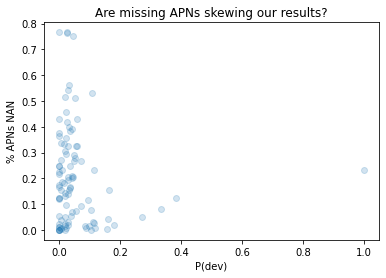

In [34]:
x = results_df["P(dev) for inventory"]
y = [utils.fraction_apns_nan(p) for c, p in cities_with_permits.items() if c in cities_with_sites]
plt.scatter(x, y, alpha=.2)
plt.xlabel("P(dev)")
plt.ylabel("% APNs NAN")
plt.title("Are missing APNs skewing our results?")

In [35]:
%%time
with HiddenPrints():
    results_geo_df = pd.DataFrame([get_results_for_city(city, match_by='geo') for city in cities])

CPU times: user 2min 57s, sys: 1.51 s, total: 2min 58s
Wall time: 2min 59s


In [36]:
results_geo_df.round(3)

,City,Mean underproduction,RHNA Success,P(inventory) for homes built,P(dev) for nonvacant sites,P(dev) for vacant sites,P(dev) for inventory,# nonvacant matches,# vacant matches,# matches
0,Berkeley,1.255,0.632,0.041,0.018,0.013,0.015,3 / 167,3 / 237,6 / 404
1,Albany,NaN,0.770,0.000,0.000,0.000,0.000,0 / 17,0 / 8,0 / 41
2,Alameda,NaN,0.697,0.000,0.143,0.273,0.222,1 / 7,3 / 11,4 / 18
3,Livermore,1.238,0.730,0.245,0.053,0.175,0.114,5 / 94,18 / 103,23 / 202
4,Fremont,0.438,1.104,0.112,0.050,0.095,0.056,7 / 141,2 / 21,9 / 162
...,...,...,...,...,...,...,...,...,...,...
92,Monte Sereno,NaN,0.770,0.000,0.000,NaN,0.000,0 / 5,0 / 0,0 / 6
93,Healdsburg,0.279,1.592,0.028,0.048,0.056,0.050,1 / 21,2 / 36,3 / 60
94,Fairfield,0.300,0.663,0.001,0.000,0.039,0.035,0 / 2,3 / 77,3 / 86
95,Sonoma,0.103,1.022,0.029,0.000,0.200,0.043,0 / 13,1 / 5,1 / 23


In [37]:
%%time
with HiddenPrints():
    results_both_df = pd.DataFrame([get_results_for_city(city, match_by='both') for city in cities])

CPU times: user 2min 49s, sys: 1.2 s, total: 2min 50s
Wall time: 2min 51s


In [38]:
results_both_df.round(3)

,City,Mean underproduction,RHNA Success,P(inventory) for homes built,P(dev) for nonvacant sites,P(dev) for vacant sites,P(dev) for inventory,# nonvacant matches,# vacant matches,# matches
0,Berkeley,1.255,0.632,0.041,0.018,0.025,0.022,3 / 167,6 / 237,9 / 404
1,Albany,NaN,0.770,0.000,0.000,0.000,0.000,0 / 17,0 / 8,0 / 41
2,Alameda,NaN,0.697,0.000,0.143,0.273,0.222,1 / 7,3 / 11,4 / 18
3,Livermore,1.238,0.730,0.245,0.096,0.233,0.163,9 / 94,24 / 103,33 / 202
4,Fremont,0.438,1.104,0.112,0.050,0.095,0.056,7 / 141,2 / 21,9 / 162
...,...,...,...,...,...,...,...,...,...,...
92,Monte Sereno,NaN,0.770,0.000,0.000,NaN,0.000,0 / 5,0 / 0,0 / 6
93,Healdsburg,0.279,1.592,0.028,0.095,0.083,0.083,2 / 21,3 / 36,5 / 60
94,Fairfield,0.300,0.663,0.001,0.000,0.039,0.035,0 / 2,3 / 77,3 / 86
95,Sonoma,0.103,1.022,0.029,0.000,0.200,0.043,0 / 13,1 / 5,1 / 23


### Histograms of QOIs

In [39]:
reload(utils)

<module 'housing_elements.utils' from '/Users/Salim/Desktop/housing-elements/housing_elements/utils.py'>

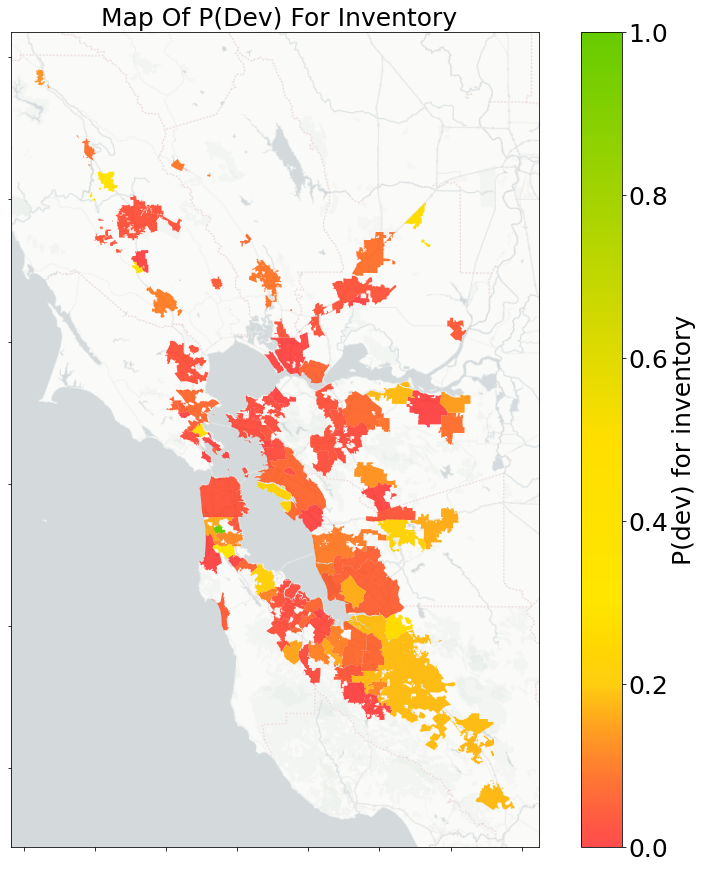

In [40]:
utils.map_qoi('P(dev) for inventory', results_both_df)

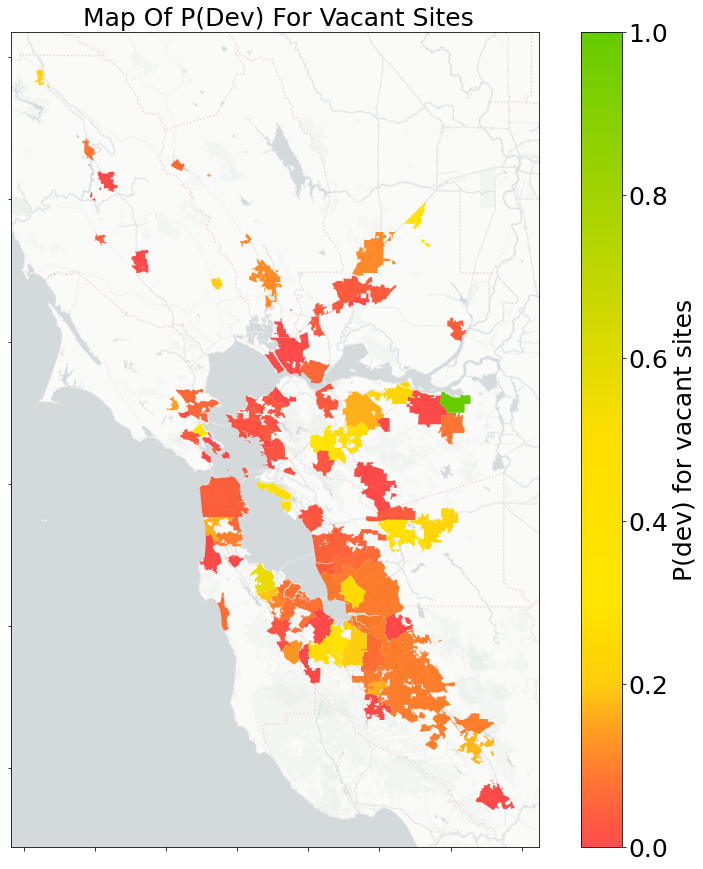

In [41]:
utils.map_qoi('P(dev) for vacant sites', results_both_df)

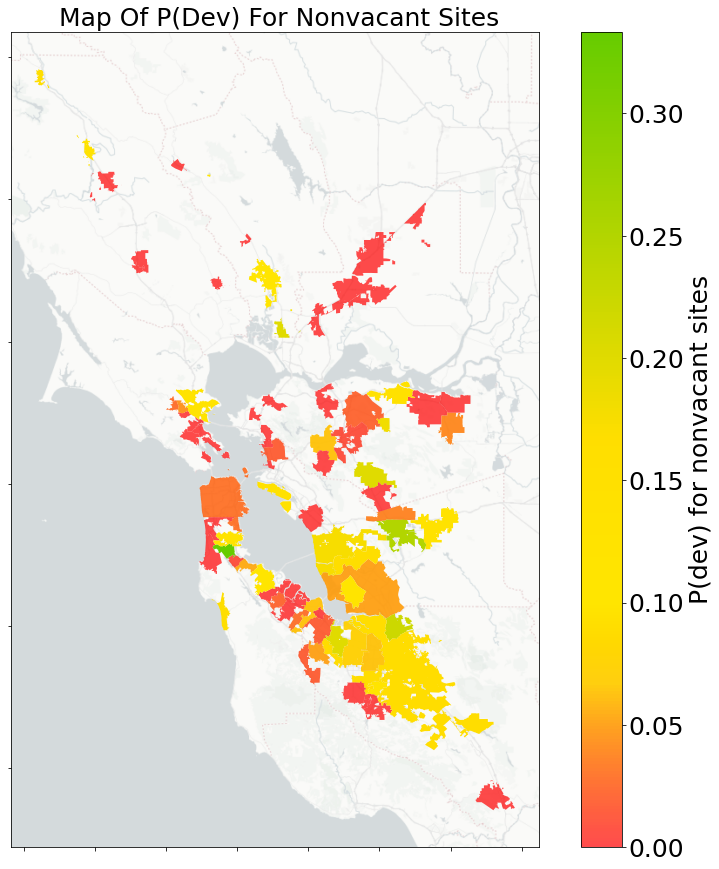

In [42]:
utils.map_qoi('P(dev) for nonvacant sites', results_both_df)

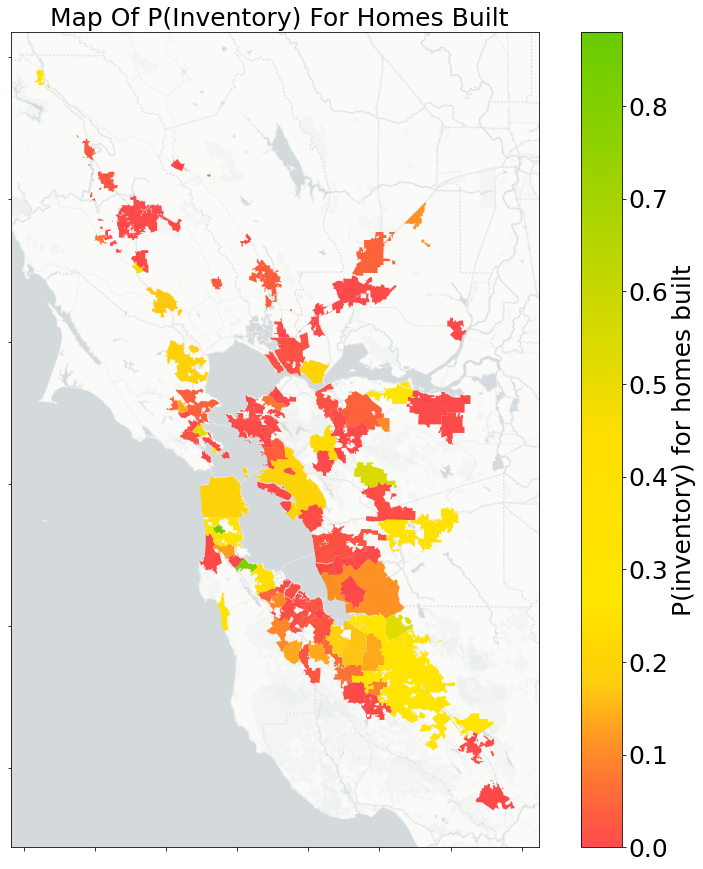

In [43]:
utils.map_qoi('P(inventory) for homes built', results_both_df)

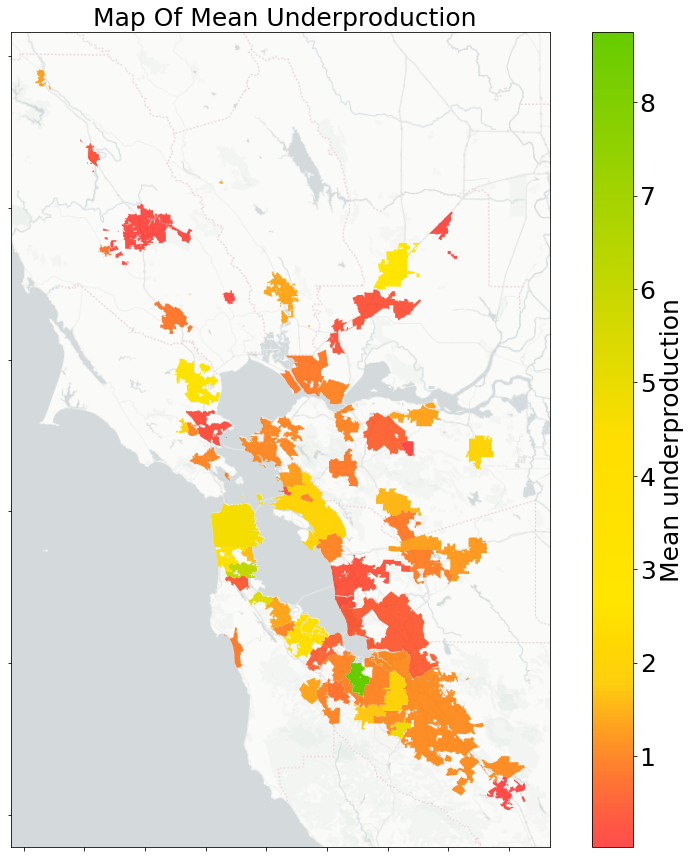

In [44]:
utils.map_qoi('Mean underproduction', results_both_df)

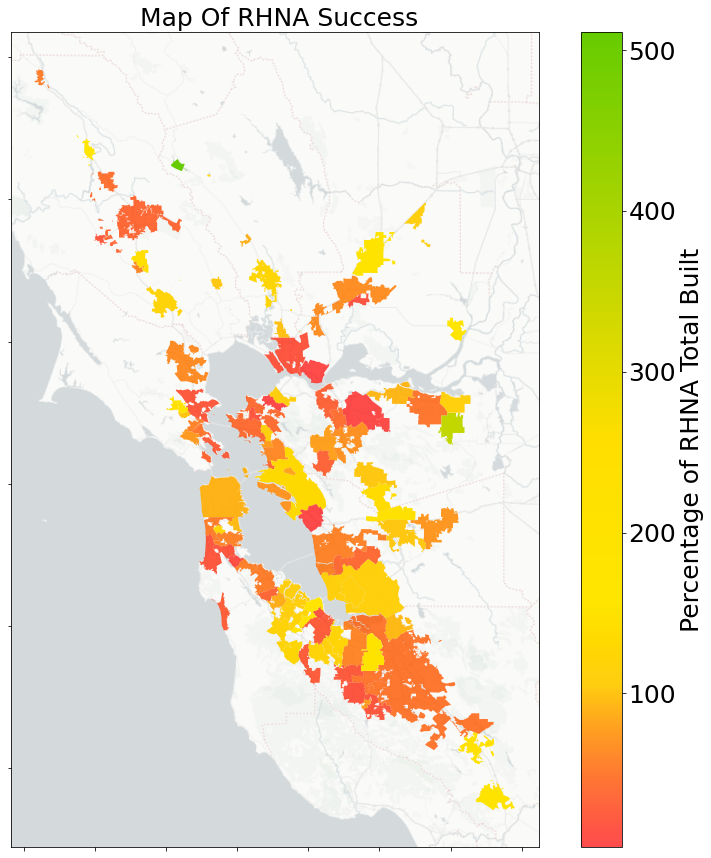

In [45]:
utils.map_qoi('RHNA Success', results_both_df)

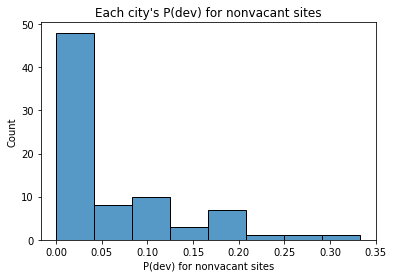

In [46]:
sea_plot = sea.histplot(results_both_df['P(dev) for nonvacant sites']).set_title("Each city's P(dev) for nonvacant sites")
sea_plot.get_figure().savefig('./figures/Pdev_nonvacant.png')

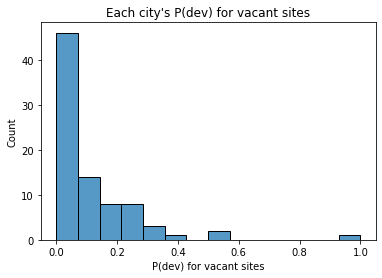

In [47]:
sea_plot = sea.histplot(results_both_df['P(dev) for vacant sites']).set_title("Each city's P(dev) for vacant sites")
sea_plot.get_figure().savefig('./figures/Pdev_vacant.png')

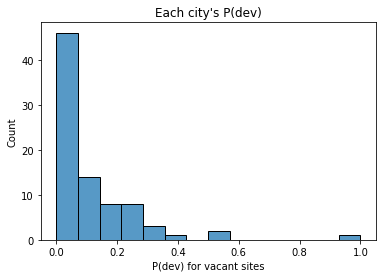

In [48]:
sea_plot = sea.histplot(results_both_df['P(dev) for vacant sites']).set_title("Each city's P(dev)")
sea_plot.get_figure().savefig('./figures/Pdev.png')

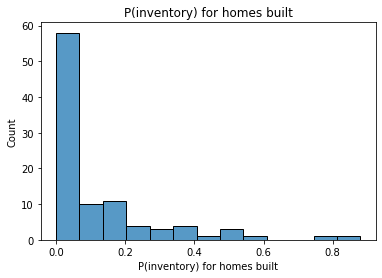

In [49]:
sea_plot = sea.histplot(results_both_df['P(inventory) for homes built']).set_title("P(inventory) for homes built")
sea_plot.get_figure().savefig('./figures/pinventory.png')

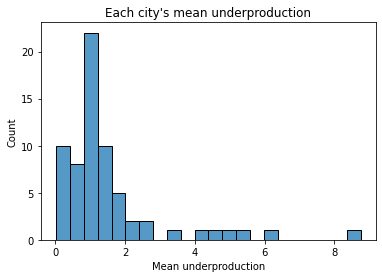

In [50]:
sea_plot = sea.histplot(results_both_df['Mean underproduction']).set_title("Each city's mean underproduction")
sea_plot.get_figure().savefig('./figures/mean_underproduction.png')

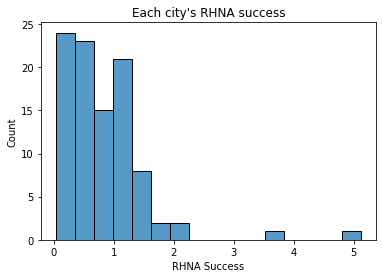

In [51]:
sea_plot = sea.histplot(results_both_df['RHNA Success']).set_title("Each city's RHNA success")
sea_plot.get_figure().savefig('./figures/rhna_succes.png')


### Did RHNA success in last cycle actually have anything to do with how good the site inventory was?

In [52]:
rhna_success = results_both_df['P(inventory) for homes built']
p_dev = results_both_df['RHNA Success']

is_null = np.isnan(rhna_success) | np.isnan(p_dev)
stats.pearsonr(rhna_success[~is_null], p_dev[~is_null])

(-0.05898729573982813, 0.56601770364845)

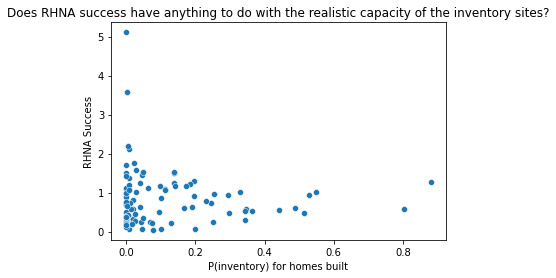

In [53]:
sea_plot = sea.scatterplot(x=rhna_success[~is_null], y=p_dev[~is_null])
sea_plot.set_title("Does RHNA success have anything to do with the realistic capacity of the inventory sites?")
sea_plot.get_figure().savefig('./figures/did_realistic_capacity_calcs_matter.png')

### Table of top 10 cities by P(dev) & bottom 10

#### Worst

In [54]:
results_both_df.sort_values(by='P(dev) for inventory').head(10)

,City,Mean underproduction,RHNA Success,P(inventory) for homes built,P(dev) for nonvacant sites,P(dev) for vacant sites,P(dev) for inventory,# nonvacant matches,# vacant matches,# matches
1,Albany,NaN,0.770149,0.0,0.0,0.0,0.0,0 / 17,0 / 8,0 / 41
92,Monte Sereno,NaN,0.770492,0.0,0.0,NaN,0.0,0 / 5,0 / 0,0 / 6
87,Suisun City,NaN,0.164356,0.0,0.0,0.0,0.0,0 / 1,0 / 31,0 / 36
85,Rohnert Park,NaN,1.414905,0.0,0.0,0.0,0.0,0 / 3,0 / 1,0 / 35
79,Saratoga,NaN,0.189066,0.0,0.0,NaN,0.0,0 / 8,0 / 0,0 / 14
30,Hercules,NaN,1.083578,0.0,NaN,0.0,0.0,0 / 0,0 / 14,0 / 14
71,Los Gatos,NaN,0.214863,0.0,0.0,0.0,0.0,0 / 6,0 / 3,0 / 36
65,East Palo Alto,NaN,0.201285,0.0,0.0,0.0,0.0,0 / 27,0 / 8,0 / 39
20,Antioch,NaN,0.498619,0.0,0.0,0.0,0.0,0 / 6,0 / 3,0 / 9
39,Tiburon,NaN,0.269231,0.0,0.0,0.0,0.0,0 / 3,0 / 2,0 / 5


#### Best

In [55]:
results_both_df.sort_values(by='P(dev) for inventory', ascending=False).head(10)

,City,Mean underproduction,RHNA Success,P(inventory) for homes built,P(dev) for nonvacant sites,P(dev) for vacant sites,P(dev) for inventory,# nonvacant matches,# vacant matches,# matches
58,Colma,2.538462,1.271186,0.880000,NaN,NaN,1.000000,0 / 0,0 / 0,1 / 1
88,Cotati,NaN,0.613139,0.488095,0.000000,0.000000,0.418605,0 / 7,0 / 31,36 / 86
96,Windsor,NaN,0.454545,0.025000,0.000000,0.000000,0.392157,0 / 3,0 / 4,20 / 51
49,San Bruno,0.426667,0.216450,0.128000,0.333333,NaN,0.333333,2 / 6,0 / 0,2 / 6
28,Corte Madera,1.000000,0.486111,0.514286,0.000000,0.300000,0.272727,0 / 1,3 / 10,3 / 11
72,Milpitas,0.468769,0.947720,0.529185,0.222222,0.000000,0.263158,4 / 18,0 / 7,45 / 171
89,Dixon,0.118490,1.055838,0.110577,0.000000,0.363636,0.263158,0 / 2,4 / 11,5 / 19
2,Alameda,NaN,0.697040,0.000000,0.142857,0.272727,0.222222,1 / 7,3 / 11,4 / 18
10,Pleasanton,0.928975,1.027092,0.330193,0.250000,0.275862,0.220588,3 / 12,8 / 29,15 / 68
57,San Mateo,1.359946,0.545806,0.442080,0.100000,0.566667,0.212766,3 / 30,17 / 30,20 / 94


In [56]:
combined_df = results_df.merge(
    results_geo_df,
    on='City',
    suffixes=[' (by APN)', ' (by geomatching)']
)

In [57]:
combined_df.round(3)

,City,Mean underproduction (by APN),RHNA Success (by APN),P(inventory) for homes built (by APN),P(dev) for nonvacant sites (by APN),P(dev) for vacant sites (by APN),P(dev) for inventory (by APN),# nonvacant matches (by APN),# vacant matches (by APN),# matches (by APN),Mean underproduction (by geomatching),RHNA Success (by geomatching),P(inventory) for homes built (by geomatching),P(dev) for nonvacant sites (by geomatching),P(dev) for vacant sites (by geomatching),P(dev) for inventory (by geomatching),# nonvacant matches (by geomatching),# vacant matches (by geomatching),# matches (by geomatching)
0,Berkeley,1.255,0.632,0.041,0.012,0.025,0.020,2 / 167,6 / 237,8 / 404,1.255,0.632,0.041,0.018,0.013,0.015,3 / 167,3 / 237,6 / 404
1,Albany,NaN,0.770,0.000,0.000,0.000,0.000,0 / 17,0 / 8,0 / 41,NaN,0.770,0.000,0.000,0.000,0.000,0 / 17,0 / 8,0 / 41
2,Alameda,NaN,0.697,0.000,0.000,0.000,0.000,0 / 7,0 / 11,0 / 18,NaN,0.697,0.000,0.143,0.273,0.222,1 / 7,3 / 11,4 / 18
3,Livermore,1.238,0.730,0.245,0.074,0.165,0.119,7 / 94,17 / 103,24 / 202,1.238,0.730,0.245,0.053,0.175,0.114,5 / 94,18 / 103,23 / 202
4,Fremont,0.438,1.104,0.112,0.028,0.048,0.031,4 / 141,1 / 21,5 / 162,0.438,1.104,0.112,0.050,0.095,0.056,7 / 141,2 / 21,9 / 162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,Monte Sereno,NaN,0.770,0.000,0.000,NaN,0.000,0 / 5,0 / 0,0 / 6,NaN,0.770,0.000,0.000,NaN,0.000,0 / 5,0 / 0,0 / 6
93,Healdsburg,0.279,1.592,0.028,0.095,0.083,0.083,2 / 21,3 / 36,5 / 60,0.279,1.592,0.028,0.048,0.056,0.050,1 / 21,2 / 36,3 / 60
94,Fairfield,0.300,0.663,0.001,0.000,0.026,0.023,0 / 2,2 / 77,2 / 86,0.300,0.663,0.001,0.000,0.039,0.035,0 / 2,3 / 77,3 / 86
95,Sonoma,0.103,1.022,0.029,0.000,0.200,0.043,0 / 13,1 / 5,1 / 23,0.103,1.022,0.029,0.000,0.200,0.043,0 / 13,1 / 5,1 / 23


In [58]:
all_df = combined_df.merge(
    results_both_df,
    on='City',
    suffixes=['', ' union']
)

In [60]:
results_df.to_csv('results/apn_matching_results.csv')
results_geo_df.to_csv('results/geo_matching_results.csv')
combined_df.to_csv('results/combined_df.csv')
results_both_df.to_csv('results/apn_or_geo_matching_results.csv')

Let's look into some cities where the APN results and Geo results are very out of line:

In [61]:
combined_df[
    (combined_df['P(dev) for nonvacant sites (by APN)'] - combined_df['P(dev) for nonvacant sites (by geomatching)']).abs() > 0.3
]

,City,Mean underproduction (by APN),RHNA Success (by APN),P(inventory) for homes built (by APN),P(dev) for nonvacant sites (by APN),P(dev) for vacant sites (by APN),P(dev) for inventory (by APN),# nonvacant matches (by APN),# vacant matches (by APN),# matches (by APN),Mean underproduction (by geomatching),RHNA Success (by geomatching),P(inventory) for homes built (by geomatching),P(dev) for nonvacant sites (by geomatching),P(dev) for vacant sites (by geomatching),P(dev) for inventory (by geomatching),# nonvacant matches (by geomatching),# vacant matches (by geomatching),# matches (by geomatching)
49,San Bruno,0.426667,0.21645,0.128,0.333333,NaN,0.333333,2 / 6,0 / 0,2 / 6,0.426667,0.21645,0.128,0.0,NaN,0.0,0 / 6,0 / 0,0 / 6


In [62]:
for column in ['P(dev) for nonvacant sites', 'P(dev) for vacant sites', 'P(dev) for inventory']:
    print(column, (combined_df[column + ' (by geomatching)'] >= combined_df[column + ' (by APN)']).mean())

P(dev) for nonvacant sites 0.7319587628865979
P(dev) for vacant sites 0.7422680412371134
P(dev) for inventory 0.8350515463917526


In [63]:
for column in ['P(dev) for nonvacant sites', 'P(dev) for vacant sites', 'P(dev) for inventory']:
    print(column, (combined_df[column + ' (by geomatching)'] == combined_df[column + ' (by APN)']).mean())

P(dev) for nonvacant sites 0.44329896907216493
P(dev) for vacant sites 0.3917525773195876
P(dev) for inventory 0.3711340206185567


# "Ground truth" data

In [64]:
def get_ground_truth_results_for_city(city: str) -> pd.DataFrame:
    if city == 'San Jose':
        permits = san_jose_permits.load_all_permits()
    elif city == 'San Francisco':
        permits = san_francisco_permits.load_all_permits()
    elif city == 'Los Altos':
        permits = los_altos_permits.load_all_permits()
    else:
        raise ValueError(f"Ground truth data not available for {city}")
        
    permits = utils.load_all_new_building_permits(city)
    sites = utils.load_site_inventory(city)
    
    return {
        'City': city,
        'Mean underproduction': utils.calculate_underproduction_on_sites(sites, permits),
        'RHNA Success': utils.calculate_rhna_success(city, permits),
        'P(inventory) for homes built': utils.calculate_pinventory_for_dev(sites, permits),
        'P(dev) for nonvacant sites': utils.calculate_pdev_for_nonvacant_sites(sites, permits),
        'P(dev) for vacant sites': utils.calculate_pdev_for_vacant_sites(sites, permits),
        'P(dev) for inventory': utils.calculate_pdev_for_inventory(sites, permits),
    }


In [65]:
permits = pd.read_csv("./data/raw_data/sf_permits.csv")
print(permits.columns)
date_cols = [c for c in permits.columns if 'Date' in c]
permits[date_cols] = permits[date_cols].apply(pd.to_datetime)

Index(['version https://git-lfs.github.com/spec/v1'], dtype='object')


In [66]:
print(permits.columns)

Index(['version https://git-lfs.github.com/spec/v1'], dtype='object')


In [67]:
%%time
ground_truth_cities = ['Los Altos', 'San Francisco', 'San Jose']
ground_truth_results_df = pd.DataFrame([get_ground_truth_results_for_city(city) for city in ground_truth_cities])

Dropping constant columns: ['rhnayrs', 'infcapcty', 'num_m', 'num_am', 'allowlow', 'jurisdict', 'county', 'num_vl', 'rhnacyc', 'num_l']
DF shape (57, 30)
Total units permitted: 532
Total rhna target: 477
Units permitted on inventory sites: 34
Total units permitted: 532


<timed exec>:2: DtypeWarning: Columns (18,22,32,35) have mixed types.Specify dtype option on import or set low_memory=False.
/Users/Salim/Desktop/housing-elements/housing_elements/san_francisco_permits.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rhna_permits.sort_values(by="Permit Type", axis=0, inplace=True)


Dropping constant columns: ['rhnayrs', 'num_m', 'num_am', 'allowlow', 'jurisdict', 'county', 'num_vl', 'currunits', 'rhnacyc', 'num_l']
DF shape (6158, 30)
Total units permitted: 26071
Total rhna target: 28869
Units permitted on inventory sites: 5079
Total units permitted: 26071
Dropping constant columns: ['rhnayrs', 'num_m', 'num_am', 'allowlow', 'jurisdict', 'county', 'num_vl', 'currunits', 'rhnacyc', 'num_l']
DF shape (599, 30)
Total units permitted: 16928.0
Total rhna target: 35080
Units permitted on inventory sites: 5011.0
Total units permitted: 16928.0
CPU times: user 58.3 s, sys: 1.78 s, total: 1min
Wall time: 1min 30s


In [68]:
ground_truth_results_df

,City,Mean underproduction,RHNA Success,P(inventory) for homes built,P(dev) for nonvacant sites,P(dev) for vacant sites,P(dev) for inventory
0,Los Altos,0.944444,1.115304,0.063910,"(3, 34, 0.08823529411764706)","(6, 23, 0.2608695652173913)","(9, 57, 0.15789473684210525)"
1,San Francisco,4.676239,0.903079,0.194814,"(95, 3915, 0.024265644955300127)","(50, 1339, 0.037341299477221805)","(145, 5254, 0.027598020555767034)"
2,San Jose,1.097829,0.482554,0.296018,"(12, 246, 0.04878048780487805)","(15, 250, 0.06)","(67, 599, 0.11185308848080133)"


# Additional summary stats for results section

In [69]:
for col in ['# matches', '# nonvacant matches', '# vacant matches']:
    values = results_both_df[col]
    num = values.str.split('/').apply(lambda x: int(x[0]))
    denom = values.str.split('/').apply(lambda x: int(x[1]))
    print(col)
    print('{:.1%}'.format(num.sum() / denom.sum()))
    print('n', denom.sum())
    print()

# matches
6.1%
n 15865

# nonvacant matches
4.0%
n 7790

# vacant matches
6.8%
n 5270



In [79]:
for col in ['P(dev) for vacant sites', 'P(dev) for nonvacant sites', 
            'P(dev) for inventory']:
    values = results_both_df[col]
    print(col)
    print('Median: {:.1%}'.format(8/5 * values.median()))
    print('Mean: {:.1%}'.format(8/5 * values.mean()))
    print()

P(dev) for vacant sites
Median: 9.4%
Mean: 17.6%

P(dev) for nonvacant sites
Median: 2.9%
Mean: 8.6%

P(dev) for inventory
Median: 8.4%
Mean: 14.2%



In [70]:
results_both_df[results_both_df['City'].isin(('Oakland', 'San Jose', 'San Francisco'))]

,City,Mean underproduction,RHNA Success,P(inventory) for homes built,P(dev) for nonvacant sites,P(dev) for vacant sites,P(dev) for inventory,# nonvacant matches,# vacant matches,# matches
17,Oakland,1.984158,1.299831,0.196540,NaN,NaN,0.069565,0 / 0,0 / 0,24 / 345
18,San Francisco,4.676239,0.903079,0.194814,0.029885,0.04705,0.034260,117 / 3915,63 / 1339,180 / 5254
70,San Jose,1.097829,0.482554,0.296018,0.089431,0.10000,0.180301,22 / 246,25 / 250,108 / 599


In [71]:
n_nans = 0
n_rows = 0
for city, sites in cities_with_sites.items(): 
    n_nans += sites.sitetype.isna().sum()
    n_rows += sites.shape[0]
print(n_nans)
print(n_rows)
print(n_nans/ n_rows)

4007
18575
0.2157200538358008


In [72]:
n_vacant, n_nonvacant, n_unknown = 0, 0, 0 
for city, sites in cities_with_sites.items(): 
    n_vacant += sites.is_vacant.sum()
    n_nonvacant  += sites.is_nonvacant.sum()
    n_unknown += sites.na_vacant.sum()
print(n_vacant, n_nonvacant, n_unknown)

6279 8120 4176


In [81]:
values = results_both_df['P(inventory) for homes built']
print('P(inventory) for homes built')
print('Median: {:.1%}'.format(values.median()))
print('Mean: {:.1%}'.format(values.mean()))
print()

P(inventory) for homes built
Median: 2.8%
Mean: 11.3%



In [75]:
pdevs = results_both_df['P(dev) for inventory']
rhnas = [utils.get_rhna_target(city) for city in cities]

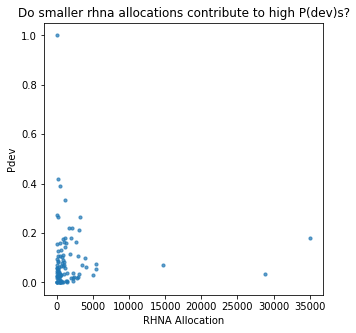

In [76]:
plt.figure(figsize=(5, 5))
plt.scatter(rhnas, pdevs, s=10, alpha=.7)
plt.xlabel("RHNA Allocation")
plt.ylabel("Pdev")
plt.title("Do smaller rhna allocations contribute to high P(dev)s?")
plt.savefig('./figures/rhna_vs_pdev.png')